# Working with AgentSets
### The Boltzmann Wealth Model

### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import mesa

c:\Users\Utente\Documents\Progetti\Shopping Model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup: The Wealth Model with Ethnicities
We'll use a slightly enriched version of the Boltzmann Wealth Model. Each agent has a
`wealth` (starting at 1) and an `ethnicity` (randomly assigned from "Green", "Blue",
or "Mixed"). This gives us meaningful attributes to query, filter, and group by.

In [2]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth and an ethnicity."""

    def __init__(self, model, ethnicity):
        super().__init__(model)
        self.wealth = 1
        self.ethnicity = ethnicity

    def exchange(self):
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.agents)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n=100):
        super().__init__()
        ethnicities = ["Green", "Blue", "Mixed"]
        MoneyAgent.create_agents(
            model=self,
            n=n,
            ethnicity=self.random.choices(ethnicities, k=n),
        )

    def step(self):
        self.agents.shuffle_do("exchange")

Let's create a model and run it for a while so agents have different wealth levels.

In [3]:
model = MoneyModel(100)
model.run_for(50)

## What is an AgentSet?
Every Mesa model automatically tracks all its agents in `model.agents`. This is an
**AgentSet** — an ordered collection of agents that provides powerful methods for
querying, filtering, and manipulating groups of agents.
You never need to create an AgentSet yourself for basic usage. Mesa creates and maintains
`model.agents` automatically whenever agents are added to or removed from the model.
Let's look at some basics:

In [4]:
# How many agents are in the model?
print(f"Total agents: {len(model.agents)}")

# Iterate over agents (just the first 5 for brevity)
for agent in model.agents.select(at_most=5):
    print(
        f"  Agent {agent.unique_id}: wealth={agent.wealth}, ethnicity={agent.ethnicity}"
    )

Total agents: 100
  Agent 1: wealth=1, ethnicity=Green
  Agent 2: wealth=2, ethnicity=Blue
  Agent 3: wealth=1, ethnicity=Blue
  Agent 4: wealth=0, ethnicity=Mixed
  Agent 5: wealth=0, ethnicity=Mixed


## Retrieving Attribute Values with `get`
The `get` method retrieves attribute values from every agent in the set, returning them
as a list. This is useful whenever you want to inspect or analyze a particular attribute
across all agents.

In [5]:
# Get all wealth values
all_wealth = model.agents.get("wealth")
print(f"First 10 wealth values: {all_wealth[:10]}")
print(f"Total wealth in economy: {sum(all_wealth)}")

First 10 wealth values: [1, 2, 1, 0, 0, 2, 0, 4, 0, 0]
Total wealth in economy: 100


You can also retrieve multiple attributes at once by passing a list of attribute names.
This returns a list of lists — one inner list per agent.

In [6]:
# Get both wealth and ethnicity for each agent
wealth_and_ethnicity = model.agents.get(["wealth", "ethnicity"])
print("First 5 agents (wealth, ethnicity):")
for values in wealth_and_ethnicity[:5]:
    print(f"  {values}")

First 5 agents (wealth, ethnicity):
  [1, 'Green']
  [2, 'Blue']
  [1, 'Blue']
  [0, 'Mixed']
  [0, 'Mixed']


### Handling missing attributes
If some agents might not have a particular attribute, you can use the `handle_missing`
parameter. By default, `get` raises an `AttributeError` for missing attributes. Setting
`handle_missing="default"` returns a default value instead.

In [7]:
# This would raise AttributeError if any agent lacks 'wealth':
# model.agents.get("nonexistent_attr")

# Safe alternative — returns None for missing attributes:
values = model.agents.get("wealth", handle_missing="default", default_value=0)
print(f"Retrieved {len(values)} values safely")

Retrieved 100 values safely


## Filtering Agents with `select`
The `select` method filters agents based on criteria, returning a new AgentSet containing
only the agents that match. This is one of the most frequently used AgentSet operations.
### Basic filtering with a function
Pass a function (often a lambda) that takes an agent and returns `True` or `False`:

In [8]:
# Select only wealthy agents (wealth >= 3)
rich_agents = model.agents.select(lambda a: a.wealth >= 3)
print(f"Rich agents (wealth >= 3): {len(rich_agents)}")

# Select agents with no money
broke_agents = model.agents.select(lambda a: a.wealth == 0)
print(f"Broke agents (wealth == 0): {len(broke_agents)}")

Rich agents (wealth >= 3): 14
Broke agents (wealth == 0): 48


### Filtering by agent type
If your model has multiple agent classes, you can filter by type using the `agent_type`
parameter. This is faster than using a lambda with `isinstance`.

In [9]:
# In this model we only have one type, but the syntax would be:
money_agents = model.agents.select(agent_type=MoneyAgent)
print(f"MoneyAgents: {len(money_agents)}")

MoneyAgents: 100


### Limiting results with `at_most`
The `at_most` parameter limits how many agents are returned. This is useful when you
only need a few agents and want to avoid processing the entire set.
- Pass an **integer** to get at most that many agents
- Pass a **float between 0 and 1** to get at most that fraction of agents
**Important:** `at_most` returns the *first* matching agents, not a random sample.
If you want a random subset, call `shuffle()` first (covered in the activation tutorial).

In [10]:
# Get at most 5 rich agents
some_rich = model.agents.select(lambda a: a.wealth >= 2, at_most=5)
print(f"Up to 5 rich agents: {len(some_rich)}")

# Get roughly 10% of agents
ten_percent = model.agents.select(at_most=0.1)
print(f"~10% of agents: {len(ten_percent)}")

Up to 5 rich agents: 5
~10% of agents: 10


### Combining criteria
You can combine `filter_func`, `agent_type`, and `at_most` in a single call. All
criteria are applied together (logical AND):

In [11]:
# At most 10 MoneyAgents with wealth > 0
subset = model.agents.select(
    filter_func=lambda a: a.wealth > 0,
    agent_type=MoneyAgent,
    at_most=10,
)
print(f"Subset size: {len(subset)}")

Subset size: 10


### Chaining selects
Since `select` returns an AgentSet, you can chain multiple calls. Each successive
`select` narrows the set further:

In [12]:
# First get Green agents, then filter for wealthy ones
wealthy_green = model.agents.select(lambda a: a.ethnicity == "Green").select(
    lambda a: a.wealth >= 3
)
print(f"Wealthy Green agents: {len(wealthy_green)}")

Wealthy Green agents: 5


## Computing Aggregates with `agg`
The `agg` method computes aggregate statistics over an attribute for all agents in
the set. Pass the attribute name and a function (like `min`, `max`, `sum`, or `np.mean`).

In [13]:
# Average wealth across all agents
avg_wealth = model.agents.agg("wealth", np.mean)
print(f"Average wealth: {avg_wealth:.2f}")

# Min and max wealth
min_wealth = model.agents.agg("wealth", min)
max_wealth = model.agents.agg("wealth", max)
print(f"Wealth range: {min_wealth} to {max_wealth}")

# Total wealth (should equal the number of agents, since money is conserved)
total = model.agents.agg("wealth", sum)
print(f"Total wealth: {total}")

Average wealth: 1.00
Wealth range: 0 to 8
Total wealth: 100


### Multiple aggregations at once
You can pass a list of functions to compute multiple statistics in a single call:

In [14]:
min_w, max_w, avg_w = model.agents.agg("wealth", [min, max, np.mean])
print(f"Min: {min_w}, Max: {max_w}, Mean: {avg_w:.2f}")

Min: 0, Max: 8, Mean: 1.00


### Aggregating subsets
Since `select` returns an AgentSet, you can chain `select` and `agg` to compute
statistics for specific subgroups:

In [15]:
# Average wealth of Green agents only
green_avg = model.agents.select(lambda a: a.ethnicity == "Green").agg("wealth", np.mean)
blue_avg = model.agents.select(lambda a: a.ethnicity == "Blue").agg("wealth", np.mean)
mixed_avg = model.agents.select(lambda a: a.ethnicity == "Mixed").agg("wealth", np.mean)

print(
    f"Average wealth — Green: {green_avg:.2f}, Blue: {blue_avg:.2f}, Mixed: {mixed_avg:.2f}"
)

Average wealth — Green: 1.41, Blue: 0.77, Mixed: 0.87


This pattern of select-then-aggregate is common, but when you want to do it for *all*
groups at once, `groupby` is more elegant.

## Grouping Agents with `groupby`
The `groupby` method splits agents into groups based on an attribute (or a callable),
returning a `GroupBy` object. This is conceptually similar to pandas' `groupby` and
is ideal when you want to analyze or act on agents by category.

In [16]:
# Group agents by ethnicity
grouped = model.agents.groupby("ethnicity")

# See how many agents are in each group
print("Agents per ethnicity:", grouped.count())

Agents per ethnicity: {'Green': 29, 'Blue': 26, 'Mixed': 45}


### Iterating over groups
A `GroupBy` object is iterable. Each iteration yields a `(group_name, agent_set)` tuple:

In [17]:
for ethnicity, group in grouped:
    avg = group.agg("wealth", np.mean)
    print(f"  {ethnicity}: {len(group)} agents, avg wealth = {avg:.2f}")

  Green: 29 agents, avg wealth = 1.41
  Blue: 26 agents, avg wealth = 0.77
  Mixed: 45 agents, avg wealth = 0.87


### Aggregating across groups
The `agg` method on `GroupBy` computes an aggregate for each group in one call:

In [18]:
# Mean wealth by ethnicity
mean_by_group = grouped.agg("wealth", np.mean)
print("Mean wealth by ethnicity:", mean_by_group)

Mean wealth by ethnicity: {'Green': np.float64(1.4137931034482758), 'Blue': np.float64(0.7692307692307693), 'Mixed': np.float64(0.8666666666666667)}


### Grouping by a function
Instead of an attribute name, you can pass a callable that computes the group key
for each agent. This is useful for creating custom groupings:

In [19]:
# Group agents into wealth brackets
def wealth_bracket(agent):
    if agent.wealth == 0:
        return "broke"
    elif agent.wealth <= 2:
        return "modest"
    else:
        return "wealthy"


brackets = model.agents.groupby(wealth_bracket)
print("Agents per wealth bracket:", brackets.count())

Agents per wealth bracket: {'modest': 38, 'broke': 48, 'wealthy': 14}


## Setting Attributes with `set`
The `set` method assigns a value to an attribute for all agents in the set. This is
useful for bulk updates — for example, applying a policy change to a group of agents.

In [20]:
# Give all broke agents a subsidy of 1
broke = model.agents.select(lambda a: a.wealth == 0)
print(f"Broke agents before subsidy: {len(broke)}")

broke.set("wealth", 1)

# Verify
still_broke = model.agents.select(lambda a: a.wealth == 0)
print(f"Broke agents after subsidy: {len(still_broke)}")

Broke agents before subsidy: 48
Broke agents after subsidy: 0


**Note:** `set` modifies agents in place and returns the AgentSet, so you can chain it:
```python
model.agents.select(lambda a: a.wealth > 10).set("taxed", True)
```

## Sorting Agents with `sort`
The `sort` method orders agents by an attribute or a custom key function. By default,
it returns a new sorted AgentSet (use `inplace=True` to sort in place).

In [21]:
# Sort by wealth (descending by default)
richest_first = model.agents.sort("wealth")
top_5 = richest_first.select(at_most=5)
print("Top 5 wealthiest agents:")
for agent in top_5:
    print(f"  Agent {agent.unique_id}: wealth={agent.wealth}")

# Sort ascending
poorest_first = model.agents.sort("wealth", ascending=True)
bottom_5 = poorest_first.select(at_most=5)
print("\nBottom 5:")
for agent in bottom_5:
    print(f"  Agent {agent.unique_id}: wealth={agent.wealth}")

Top 5 wealthiest agents:
  Agent 97: wealth=8
  Agent 17: wealth=6
  Agent 8: wealth=4
  Agent 72: wealth=4
  Agent 14: wealth=3

Bottom 5:
  Agent 1: wealth=1
  Agent 3: wealth=1
  Agent 4: wealth=1
  Agent 5: wealth=1
  Agent 7: wealth=1


## Converting to a List
If you need standard list operations like indexing or slicing, use the `to_list()` method
to convert the AgentSet to a plain Python list:

In [22]:
agent_list = model.agents.to_list()
print(f"First agent: {agent_list[0].unique_id}")
print(f"Last agent: {agent_list[-1].unique_id}")

First agent: 1
Last agent: 100


## Putting It Together: Analyzing the Model
Let's combine what we've learned to produce a summary analysis of the model state.

In [23]:
print("=== Model Summary After 50 Steps ===\n")

# Overall statistics
min_w, max_w, avg_w, total_w = model.agents.agg("wealth", [min, max, np.mean, sum])
print(f"Agents: {len(model.agents)}")
print(
    f"Total wealth: {total_w} (conserved: {'yes' if total_w == len(model.agents) else 'no, subsidy applied'})"
)
print(f"Wealth range: {min_w} to {max_w}, mean: {avg_w:.2f}\n")

# By ethnicity
print("By ethnicity:")
for ethnicity, group in model.agents.groupby("ethnicity"):
    count = len(group)
    avg = group.agg("wealth", np.mean)
    broke = len(group.select(lambda a: a.wealth == 0))
    print(
        f"  {ethnicity:6s}: {count:3d} agents, avg wealth = {avg:.2f}, broke = {broke}"
    )

# Wealth distribution
print("\nWealth brackets:")
for bracket, group in model.agents.groupby(wealth_bracket):
    print(f"  {bracket:8s}: {len(group)} agents")

=== Model Summary After 50 Steps ===

Agents: 100
Total wealth: 148 (conserved: no, subsidy applied)
Wealth range: 1 to 8, mean: 1.48

By ethnicity:
  Green :  29 agents, avg wealth = 1.79, broke = 0
  Blue  :  26 agents, avg wealth = 1.19, broke = 0
  Mixed :  45 agents, avg wealth = 1.44, broke = 0

Wealth brackets:
  modest  : 86 agents
  wealthy : 14 agents


## Visualizing the Results

[Text(0.5, 1.0, 'Wealth distribution by ethnicity'),
 Text(0.5, 0, 'Wealth'),
 Text(0, 0.5, 'Number of agents')]

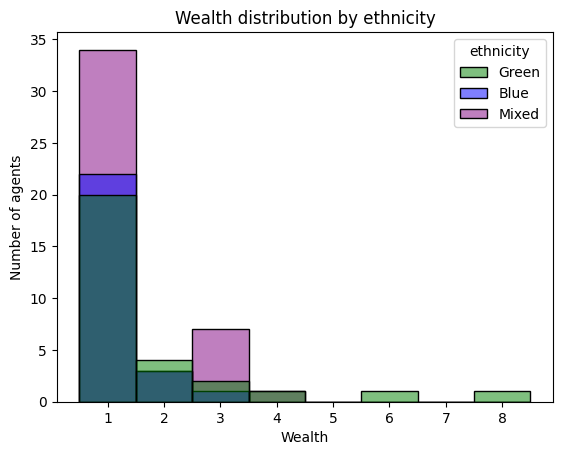

In [24]:
# Collect data for plotting
data = []
for agent in model.agents:
    data.append({"wealth": agent.wealth, "ethnicity": agent.ethnicity})
df = pd.DataFrame(data)

palette = {"Green": "green", "Blue": "blue", "Mixed": "purple"}
g = sns.histplot(data=df, x="wealth", hue="ethnicity", discrete=True, palette=palette)
g.set(
    title="Wealth distribution by ethnicity", xlabel="Wealth", ylabel="Number of agents"
)

## Summary
In this tutorial you learned the core AgentSet **query** methods:
| Method | Purpose |
|---|---|
| `get(attr)` | Retrieve attribute values from all agents |
| `select(func)` | Filter agents by criteria |
| `agg(attr, func)` | Compute aggregate statistics |
| `groupby(attr)` | Group agents by attribute or function |
| `set(attr, value)` | Bulk-assign attribute values |
| `sort(key)` | Order agents by attribute |
| `to_list()` | Convert to a plain Python list |
These methods are about *inspecting* and *organizing* agents. In the next tutorial,
we'll cover how to **activate** agents — making them actually *do* things — using
`do`, `shuffle_do`, and `map`.